# Model selection

Cross-validation is used here to select the best model. In this script it is used to test the best machine learning model for use in this context.

<u>Tests using the following models :</u>
* Linear regression
* Random forest regressor
* XGBoost
* Extra Trees Regressor

<u> The following variables are included in the model:</u>
* Weather variables (rain, temperature, windspeed)
* Time variables (Day of week, month, year, time of day, public holiday)
* Sensor environment variables (within a 500m buffer of the sensor):
    * Betweenness of the street 
    * Buildings in proximity to the sensor
    * Landmarks in proximity to the sensor  
    * Furniture in proximity to the sensor    
    * Lights in proximity to the sensor   

In [1]:
# !pip install -q scikit-learn-extra

In [1]:
import sklearn_extra
from sklearn_extra.cluster import KMedoids
from pyclustering.cluster import cluster_visualizer
from sklearn.cluster import KMeans

In [25]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
from sklearn.pipeline import Pipeline
import folium
import branca.colormap as cm
# from eli5.sklearn import PermutationImportance
import joblib
import os
import psutil
import geopy.distance
from sklearn.model_selection import TimeSeriesSplit
import time as time
import sklearn_extra
from sklearn_extra.cluster import KMedoids
#  Spatial packages
from shapely.geometry import Point
import geopandas as gpd
import contextily as cx
import matplotlib.colors as colors
# Machine learning packages
# import xgboost as xgb

from Functions import *

#https://goldinlocks.github.io/Time-Series-Cross-Validation/ 
class BlockingTimeSeries_withSpatial_Split():
    def __init__(self, n_temporal_splits, n_spatial_clusters, temporal_testing_fraction, datetimes, plot):
        self.n_temporal_splits = n_temporal_splits
        self.n_spatial_clusters = n_spatial_clusters
        self.datetimes = datetimes
        self.temporal_testing_fraction = temporal_testing_fraction
        
    def get_n_splits(self, X, y, groups):
        return self.n_temporal_splits
    
    def get_n_spatial_splits(self, X, y, groups):
        return self.n_spatial_clusters  
    
    @staticmethod
    def plot_spatially(melbourne_sensors_in_this_timeslice, n_spatial_clusters,temporal_i,ax):
        
        # Plot
        geometry = [Point(xy) for xy in zip(melbourne_sensors_in_this_timeslice.Longitude,
                                            melbourne_sensors_in_this_timeslice.Latitude)]
        gdf = gpd.GeoDataFrame(melbourne_sensors_in_this_timeslice, geometry=geometry)
        gdf = gdf.set_crs('EPSG:4326')
        gdf = gdf.to_crs('epsg:3857')
        colors_ls = ['black'] * n_spatial_clusters
        color = ['red', 'green', 'blue', 'purple', 'yellow', 'orange','brown','indigo','violet','cyan']

        gdf.plot(column=gdf.Cluster_number, ax = ax[temporal_i], markersize = 100, cmap=colors.ListedColormap(color))
        cx.add_basemap(ax = ax[temporal_i])
        ax[temporal_i].axis('off')
        #colors_ls[num] = 'black';
        ax[temporal_i].set_axis_off()
    
    
    @staticmethod    
    def run_cluster_analysis(X, start, stop, melbourne_sensors, n_spatial_clusters, temporal_i, ax, plot):
            
            ##############################################################
            # Get data for just the timeslice being considered (defined by start:stop)
            # And then get a list of sensors which have data during this timeslice
            ##############################################################
            # Add sensor IDs to the data
            X['sensor_id'] = sensor_ids
            # Get list of sensors which have data in this time block
            list_sensors_this_timeslice = X.iloc[start :stop]['sensor_id'].unique().tolist()
            
            ##############################################################
            # Run K-means clustering using just these sensors (i.e. with data in this timeslice)
            # Based on coordinates of sensors
            ##############################################################            
            # Get dataframe containing coordinates for these sensors
            melbourne_sensors_in_this_timeslice = melbourne_sensors[melbourne_sensors['sensor_id'].isin(list_sensors_this_timeslice)].copy()
            coordinates_to_cluster = melbourne_sensors_in_this_timeslice[['Latitude','Longitude']].copy()   

            # Initialize KMeans instance
            kmeans = KMeans(n_clusters=n_spatial_clusters, random_state=0).fit(coordinates_to_cluster)
            # coordinates_to_cluster['Kmeans_clusternum'] = kmeans.labels_

            ##############################################################
            # Join back on to main dataset (X) 
            # So now X includes a column containing the cluster number of each row
            # If the row is from a sensor not present in this timeslice, it will have NA
            # Rows not within this timeslice, but with a sensor ID present in this timeslice
            # will get the cluster number for that sensor in this timeslice, but this will be overridden
            # in the future when that timeslice is considered
            ##############################################################      
            # Join the cluster number back onto the dataset of sensors present in this timeslice
            melbourne_sensors_in_this_timeslice['Cluster_number'] = kmeans.labels_

            # Remove a cluster number column if it was already created in previous iteration
            if 'Cluster_number' in X.columns:
                X = X.drop('Cluster_number', axis=1)
            
            # Join this onto X (so now all rows with that sensor_id will show as being in that cluster)
            # Including rows not within this timeslice, but this shouldn't matter
            X = pd.merge(X, melbourne_sensors_in_this_timeslice[['sensor_id','Cluster_number']], on='sensor_id', how='left')

            ##############################################################
            # Send to plotting function
            ##############################################################
            if plot == True:
                BlockingTimeSeries_withSpatial_Split.plot_spatially(melbourne_sensors_in_this_timeslice,
                                                                   n_spatial_clusters, temporal_i, ax)
            
            return X
            
    
    def split(self, X, datetimes, y=None, groups=None):
        # Define number of samples
        n_samples = len(X)
        # Define how many samples will be in each of the folds (number of samples divided by number of splits)
        k_fold_size = n_samples // self.n_temporal_splits
        # Get an indice for every value in the dataset
        indices = np.arange(n_samples)
                
        # I think the margin is about leaving a space between folds
        margin = 0
        
        ###############################################################
        ###############################################################
        # For each of the temporal folds
        ###############################################################
        ###############################################################
        plot = fig, ax = plt.subplots(ncols = self.n_temporal_splits, figsize=(20,20))
        for temporal_i in range(self.n_temporal_splits):
            print(f"Temporal split number {temporal_i}")

            # Find the start, and end index of the temporal split
            start = temporal_i * k_fold_size
            stop = start + k_fold_size
            # Find the mid point of this split (where the testing data stops and training starts)
            mid = int(self.temporal_testing_fraction * (stop - start)) + start
            # Get the indices equating to the rows which will be in the training and testing portions for this temporal split
            training_indices = pd.Series (indices[start: mid])
            test_indices =pd.Series(indices[mid + margin: stop])
            print(start, stop)
            print(f"Start: {self.datetimes[start]}, end: {self.datetimes[stop]}")
            
            ###############################################################
            ###############################################################
            # For the portion of data being used in this timeslice (incl. both testing and training):
                # Assign sensor's to clusters (using only the sensors present in this timeslice, sensors not 
                # in this timeslice will get a NA for cluster_number)
            ###############################################################
            ###############################################################
            X_thistimeslice = BlockingTimeSeries_withSpatial_Split.run_cluster_analysis(X=X, start = start , stop =stop,
                             melbourne_sensors= melbourne_sensors, n_spatial_clusters=self.n_spatial_clusters, 
                             temporal_i=temporal_i, ax=ax, plot = True)
            
            ###############################################################
            ###############################################################
            # Create n_spatial_clusters versions of this temporal fold
            # In each case only using the training rows found within n_spatial_clusters - 1 of the clusters
            # and only keeping testing rows found within the other row
            ###############################################################
            ###############################################################
            # For each of the spatial clusters
            for spatial_i in range(len(list(range(0,self.n_spatial_clusters)))):
                # print(f"Spatial split number {spatial_i}")
                
                # For this spatial iteration, create lists to store the training and testing indices 
                this_cluster_trainingindices = []
                this_cluster_testingindices = []

                # For this spatial iteration, define the clusters which will be used in testing and training
                training_clusters = list(range(0,self.n_spatial_clusters))
                training_clusters.pop(spatial_i)
                testing_clusters = [spatial_i]
                
                # Find the indices of rows which 
                this_cluster_trainingindices = X_thistimeslice.iloc[training_indices][X_thistimeslice.iloc[training_indices]['Cluster_number'].isin(training_clusters)].index.values.tolist()
                this_cluster_testingindices = X_thistimeslice.iloc[test_indices][X_thistimeslice.iloc[test_indices]['Cluster_number'].isin(testing_clusters)].index.values.tolist()
                
                #print(f"Clusters {training_clusters} being used here in training. "
                #      f"There are {len(this_cluster_trainingindices)} rows of training data in this cluster")
                      
                # print(f"Clusters {testing_clusters} being used here in testing. "
                #     f"There are {len(this_cluster_testingindices)} rows of testing data in this cluster")
                
                print(f"Testing data is {round((len(this_cluster_testingindices)/len(this_cluster_trainingindices))*100,1)}"
                      f"% of training data")
                
                yield np.array(this_cluster_trainingindices), np.array(this_cluster_testingindices)
                
        return plot

### Get data

In [4]:
buffer_size_m = 500
input_csv ="../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m)
Xfull, Yfull, data_time_columns = prepare_x_y_data(input_csv)

### Test kmediods

In [31]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES
from pyclustering.cluster import cluster_visualizer

In [27]:
X=Xfull
# Add sensor IDs to the data
X['sensor_id'] = sensor_ids

start = 0
stop = 1376360

# Get list of sensors which have data in this time block
list_sensors_this_timeslice = X.iloc[start :stop]['sensor_id'].unique().tolist()

##############################################################
# Run K-means clustering using just these sensors (i.e. with data in this timeslice)
# Based on coordinates of sensors
##############################################################            
# Get dataframe containing coordinates for these sensors
melbourne_sensors_in_this_timeslice = melbourne_sensors[melbourne_sensors['sensor_id'].isin(list_sensors_this_timeslice)].copy()
coordinates_to_cluster = melbourne_sensors_in_this_timeslice[['Latitude','Longitude']].copy()   

# Initialize KMeans instance
kmeans = KMeans(n_clusters=n_spatial_clusters, random_state=0).fit(coordinates_to_cluster)

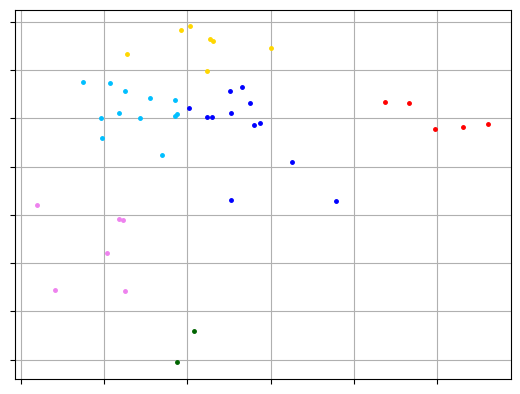

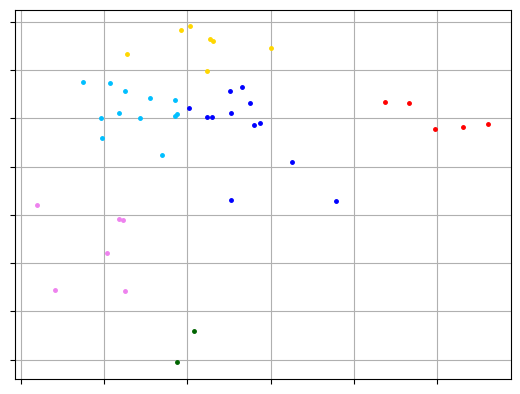

In [51]:
# Initialize K-Medoids with 3 clusters and random initial medoids
initial_medoids = np.random.choice(len(np.array(coordinates_to_cluster)), 6, replace=True).tolist()
# initial_medoids
kmedoids_instance = kmedoids(np.array(coordinates_to_cluster).tolist(), initial_medoids)
# # Run K-Medoids clustering
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
# Visualize the clusters
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, np.array(coordinates_to_cluster).tolist())
visualizer.show()

In [1]:
# def balance_clusters(clusters, desired_size=None):
#     """Balance the size of clusters by moving points from larger clusters to smaller ones."""
#     if desired_size is None:
#         desired_size = sum(len(cluster) for cluster in clusters) // len(clusters)

#     overflow = []  # Points that are in clusters that are too large
#     underflow = []  # Clusters that are too small

#     for cluster in clusters:
#         while len(cluster) > desired_size:
#             overflow.append(cluster.pop())
#         while len(cluster) < desired_size:
#             underflow.append(cluster)

#     for point in overflow:
#         underflow[0].append(point)
#         if len(underflow[0]) == desired_size:
#             underflow.pop(0)

#     return clusters

# # Balance the clusters
# balanced_clusters = balance_clusters(clusters)

# # Visualize the balanced clusters
# visualizer = cluster_visualizer()
# visualizer.append_clusters(balanced_clusters, np.array(coordinates_to_cluster).tolist())
# visualizer.show()

In [5]:
melbourne_sensors = pd.read_csv("../Data/FootfallData/melbourne_locations.csv")

### Add sensor id and datetime

In [6]:
sensor_ids = pd.read_csv(input_csv)['sensor_id']
datetimes = pd.read_csv(input_csv)['datetime']

### Print spatial locations of sensor (need footfall_spatial environment)

Temporal split number 0
0 1376360
Start: 2011-01-01 00:00:00, end: 2017-01-02 09:00:00


KeyboardInterrupt: 

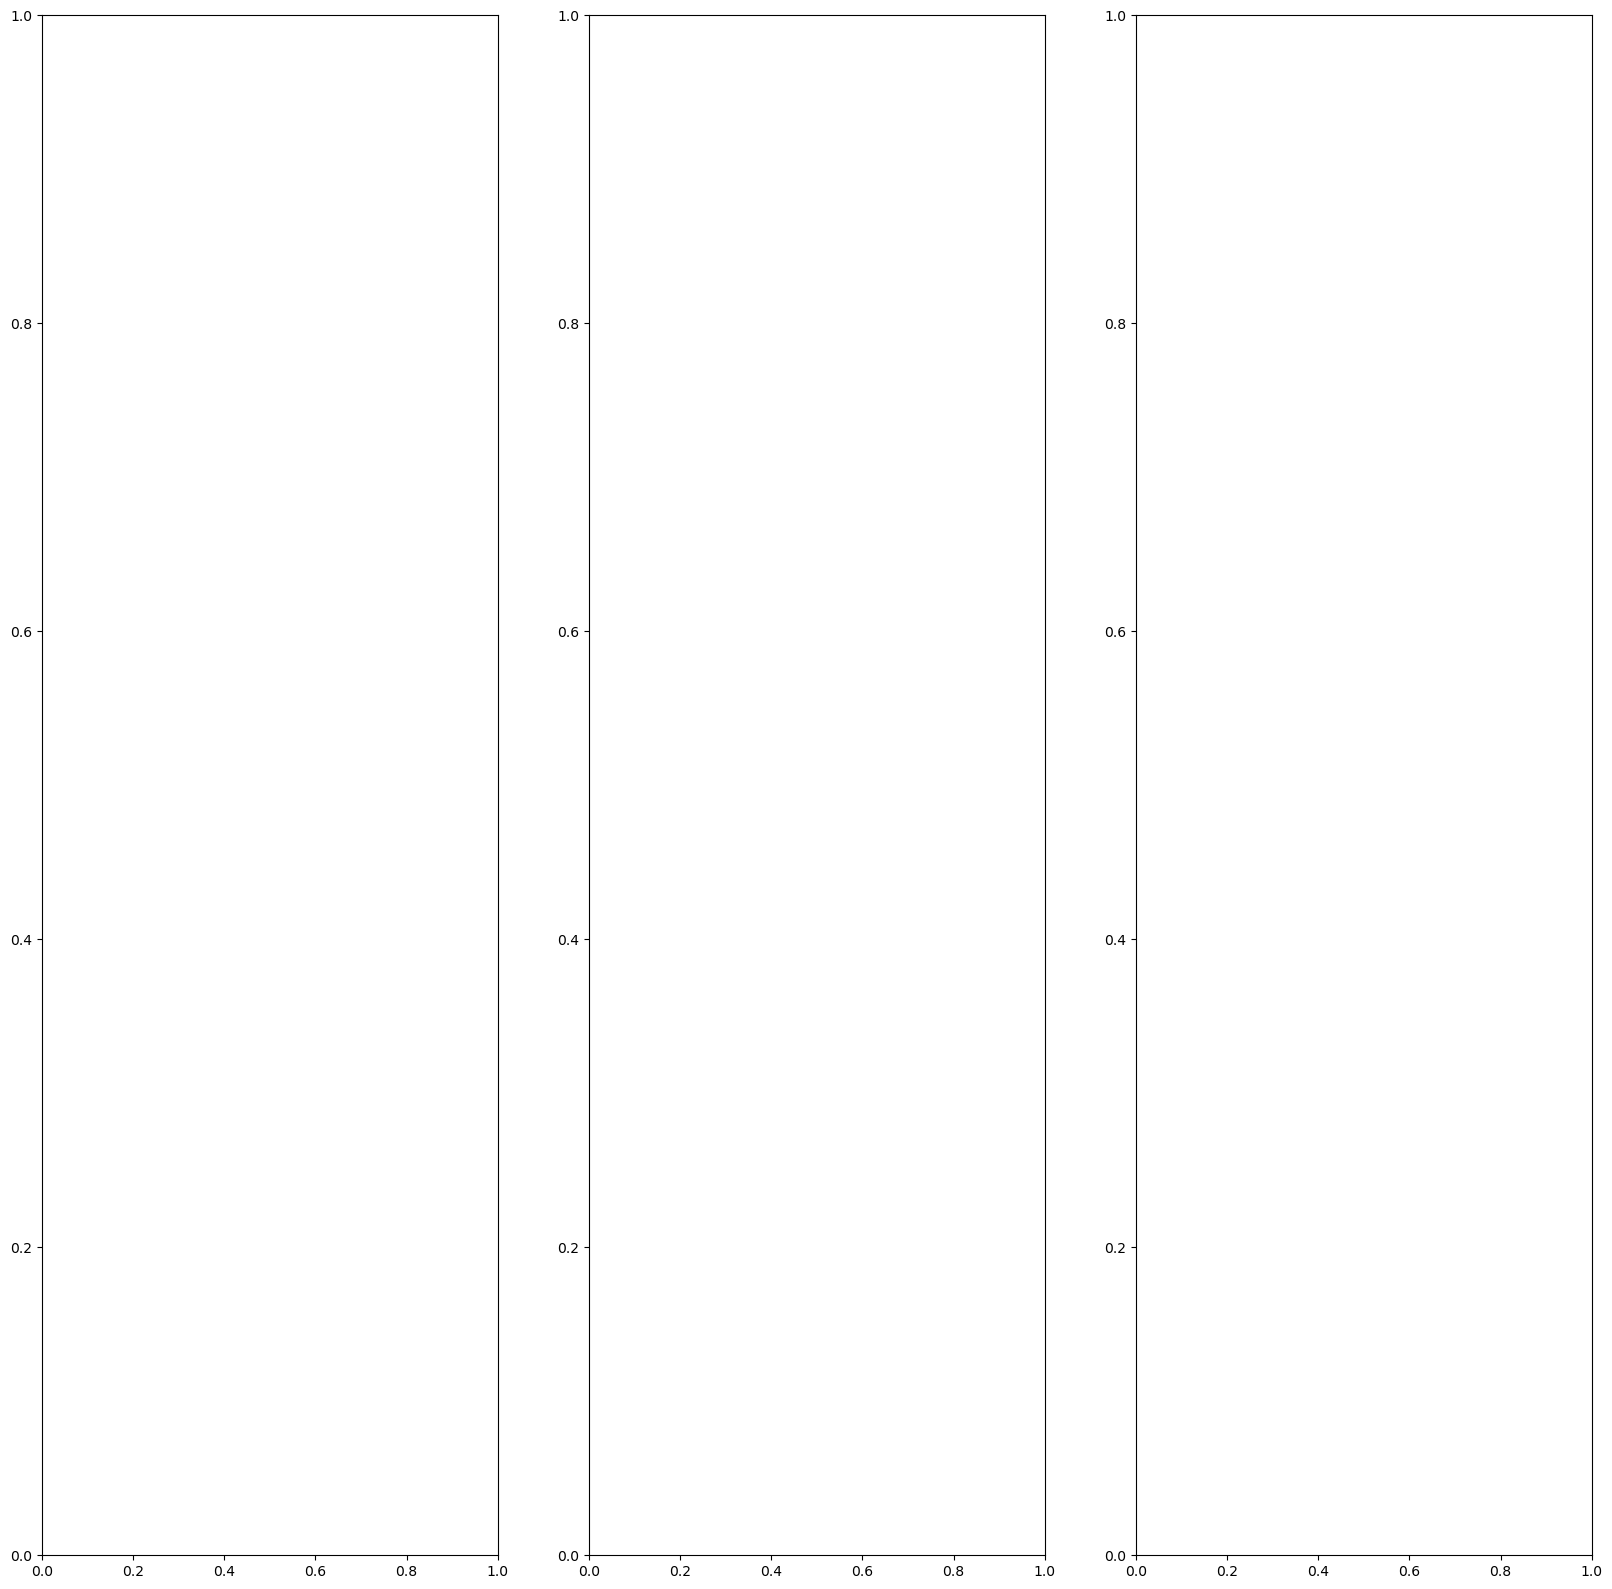

In [26]:
# # Create the BlockedTimeSeriesSplit object
n_temporal_blocks=3
n_spatial_clusters = 4
btss = BlockingTimeSeries_withSpatial_Split(n_temporal_splits=n_temporal_blocks, n_spatial_clusters = n_spatial_clusters,
                                           temporal_testing_fraction = 0.8, datetimes = datetimes, plot =True)
# Plot the fold indices
for fold, (train_index, test_index) in enumerate(btss.split(Xfull, datetimes)):
     pass
#     plt.figure(figsize=(8, 3))
#     plt.plot(np.arange(len(Yfull)), np.zeros_like(Yfull), 'r-', lw=2, label='Data')
#     plt.scatter(train_index, np.zeros_like(train_index), c='b', marker='o', label='Train')
#     plt.scatter(test_index, np.zeros_like(test_index), c='g', marker='o', label='Test')
#     plt.title(f'Fold {fold+1}')
#     plt.legend(loc='upper left')
#     plt.ylim(-0.1, 0.1)
#     plt.show()

In [8]:
# Xfull.columns

In [9]:
# # Create the BlockedTimeSeriesSplit object
# n_temporal_blocks=4
# btss = BlockingTimeSeries_withSpatial_Split(n_temporal_splits=n_temporal_blocks, n_spatial_clusters = 5)

# # Plot the fold indices
# for fold, (train_index, test_index) in enumerate(btss.split(Xfull)):
#     plt.figure(figsize=(8, 3))
#     plt.plot(np.arange(len(Yfull)), np.zeros_like(Yfull), 'r-', lw=2, label='Data')
#     plt.scatter(train_index, np.zeros_like(train_index), c='b', marker='o', label='Train')
#     plt.scatter(test_index, np.zeros_like(test_index), c='g', marker='o', label='Test')
#     plt.title(f'Fold {fold+1}')
#     plt.legend(loc='upper left')
#     plt.ylim(-0.1, 0.1)
#     plt.show()

## Run models with cross-validation

### Define the error metrics for the cross-validation to return, and the parameters of the cross validation

In [8]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']

In [9]:
lr_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['linear_regressor',LinearRegression()]])
rf_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['rf_regressor', RandomForestRegressor(random_state = 1, n_jobs = 10)]])
xgb_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['xgb_regressor',xgb.XGBRegressor(random_state=1, n_jobs = 16)]])
et_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['et_regressor',ExtraTreesRegressor (random_state = 1, n_jobs = 16)]])

NameError: name 'xgb' is not defined

In [ ]:
# models_dict = {"rf_regressor":rf_model_pipeline,
#                "linear_regressor": lr_model_pipeline, "xgb_regressor":xgb_model_pipeline}

models_dict = {"rf_regressor":rf_model_pipeline}

### Prepare data for modelling

### Remove year

In [13]:
# del Xfull['year']

### Choose which month_num and weekday_num option to include

In [ ]:
# If using the dummy variables
# Xfull.drop(['Cos_month_num', 'Sin_month_num', 'Cos_weekday_num', 'Sin_weekday_num'], axis=1)
# If using the cyclical variables
Xfull.drop(['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'], axis=1, inplace = True)

### Run model with cross validation

In [ ]:
# Dataframe to store the scores for all the models
error_metric_scores = pd.DataFrame()

for model_name, model_pipeline in models_dict.items():
    print(model_name)
    # Use cross_validate to return the error scores associated with this model and this data
    start = time()
    model_output = cross_validate(model_pipeline, Xfull, Yfull, cv=btss, scoring=error_metrics, error_score="raise")
    end = time()
    print('Ran in {} minutes'.format(round((end - start)/60),2))
    
    # Formulate the different error scores into a dataframe
    error_metrics_df =pd.DataFrame({'mae': round(abs(model_output['test_neg_mean_absolute_error'].mean()),2), 
                  'mape': round(abs(model_output['test_neg_mean_absolute_percentage_error'].mean()),2),
                  'r2': round(abs(model_output['test_r2'].mean()),2), 
                  'rmse': round(abs(model_output['test_neg_root_mean_squared_error'].mean()),2)},
                 index =[model_name])
        
    # Add evaluation metric scores for this model to the dataframe containing the metrics for each model
    error_metric_scores = error_metric_scores.append(error_metrics_df)
    # Save error scores for this distance to file
    error_metrics_df.to_csv('Results/CV/ComparingModels/{}_{}m_error_metric_scores.csv'.format(model_name,buffer_size_m),index=False)    

# Save dataframes of error metrics for each buffer distance 
error_metric_scores.to_csv('Results/CV/ComparingModels/comparingmodels_error_metric_scores.csv')   

### Print table showing error metrics associated with each model

In [68]:
error_metric_scores

,mae,mape,r2,rmse
rf_regressor,100.29,2.631653e+15,0.75,199.69
rf_regressor,100.29,2.631653e+15,0.75,199.69
rf_regressor,100.29,2.631653e+15,0.75,199.69
rf_regressor,100.29,2.631653e+15,0.75,199.69
rf_regressor,58.35,1.438735e+15,0.94,120.87
rf_regressor,100.29,2.631653e+15,0.75,199.69


In [42]:
error_metric_scores

,mae,mape,r2,rmse
rf_regressor,327.36,7.759219e+15,1.57,498.29


Temporal split number 0
Start: 2011-01-01 00:00:00, end: 2015-12-25 23:00:00
Testing data is 17.1% of training data
Testing data is 3.7% of training data
Testing data is 2.2% of training data
Temporal split number 1
Start: 2015-12-25 23:00:00, end: 2018-11-17 10:00:00
Testing data is 2.5% of training data
Testing data is 14.7% of training data
Testing data is 3.8% of training data
Temporal split number 2
Start: 2018-11-17 10:00:00, end: 2021-01-25 04:00:00
Testing data is 4.6% of training data
Testing data is 12.8% of training data
Testing data is 2.2% of training data
Temporal split number 3
Start: 2021-01-25 04:00:00, end: 2022-10-31 23:00:00
Testing data is 12.3% of training data
Testing data is 3.3% of training data
Testing data is 3.8% of training data


ValueError: cross_val_predict only works for partitions

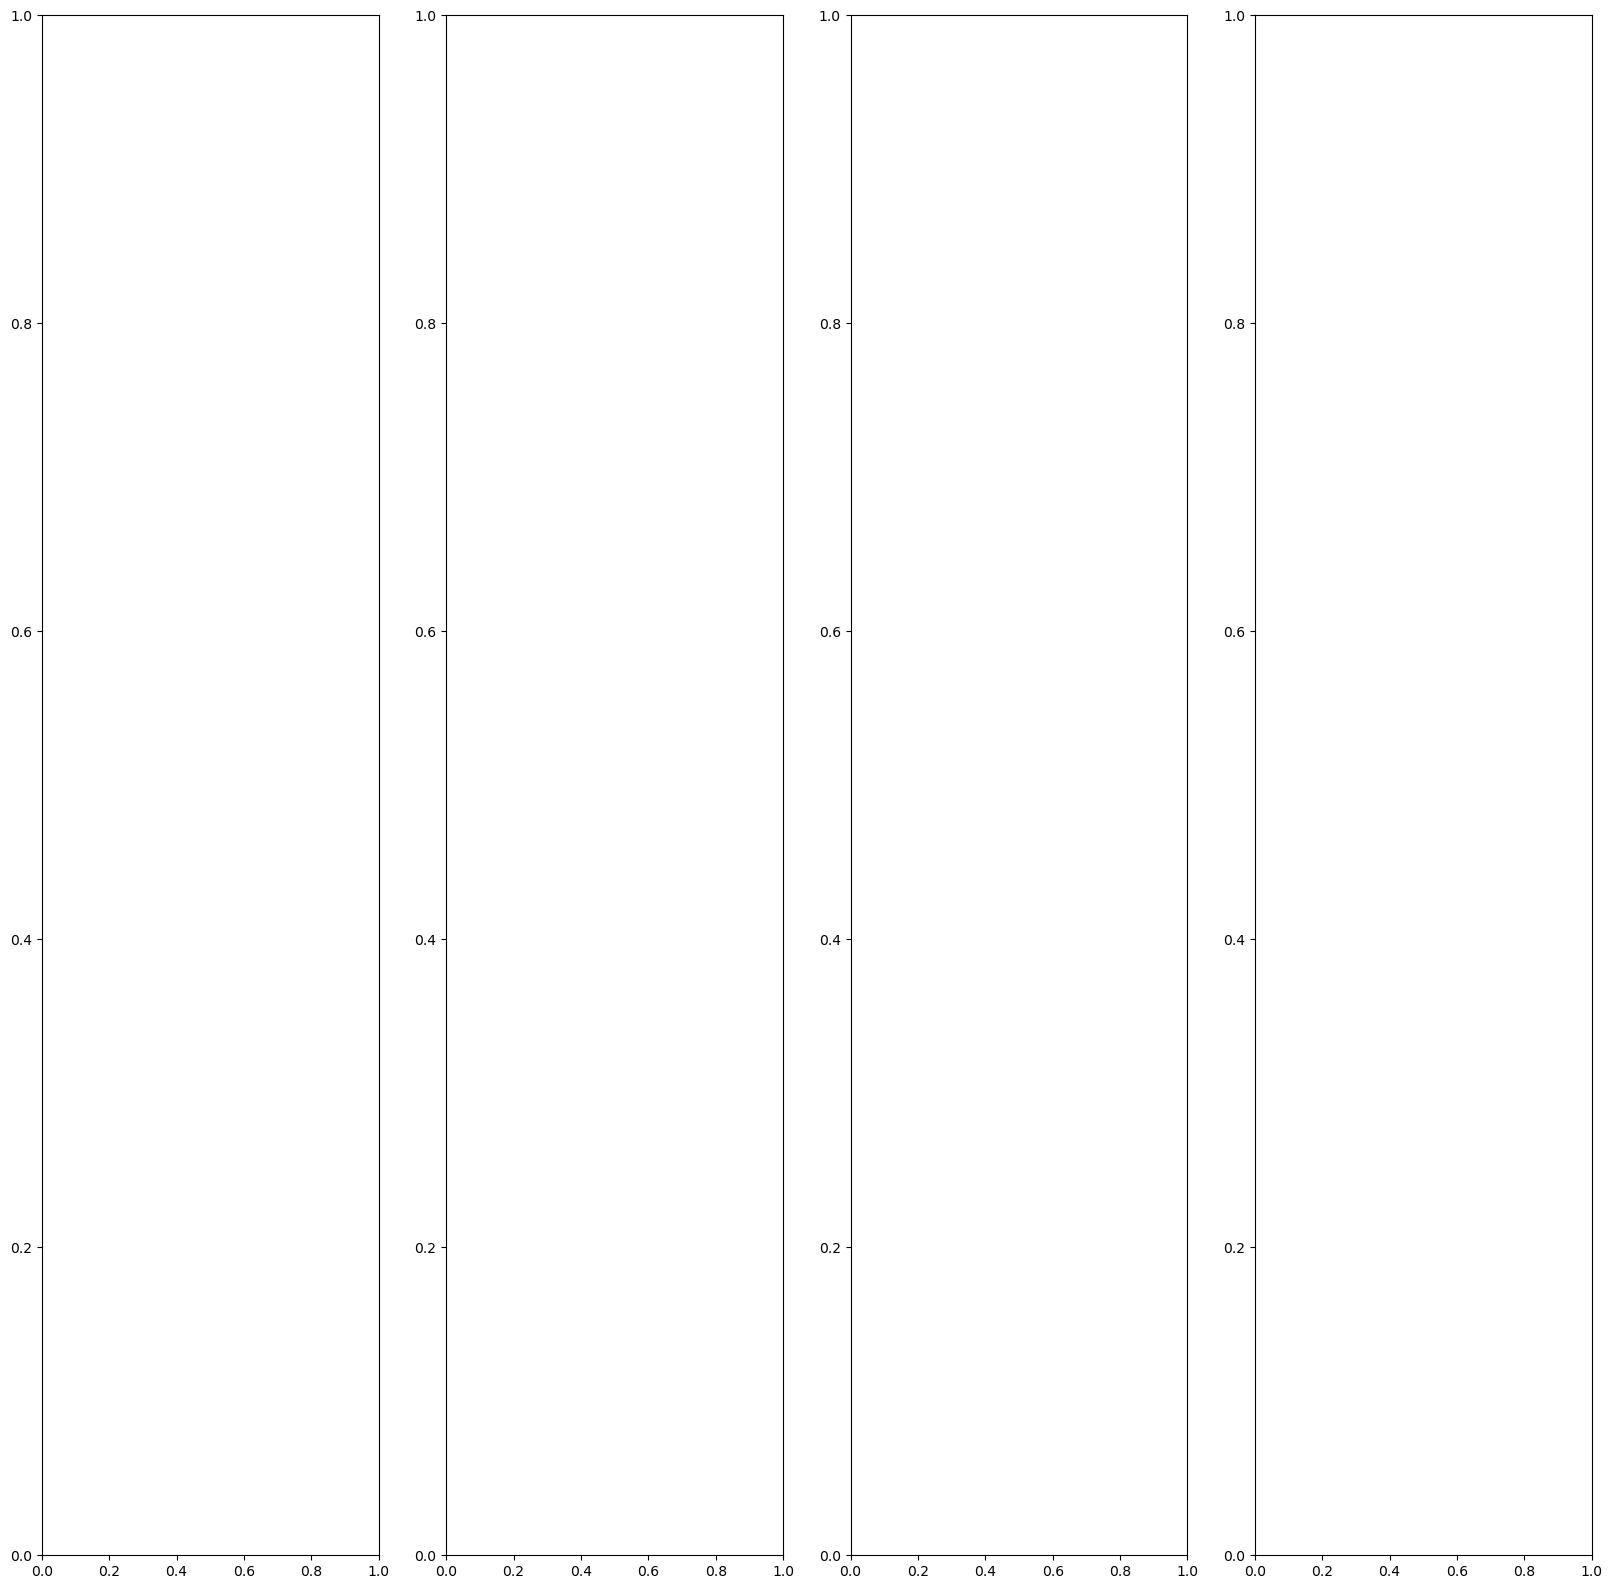

In [43]:
#### Run cross_val_predict to get predictions
start = time()
predictions = cross_val_predict(rf_model_pipeline, Xfull, Yfull,cv=btss)
end = time()
print('Ran cross_val_predict in {} minutes'.format(round((end - start)/60),2))
# Convert to a dataframe
predictions_df=pd.DataFrame(predictions)
# Store the predictions
# predictions_df.to_csv('Results/CV/ModelEvaluation_WithCV/predictions_RF_{}.csv'.format(buffer_size_m),index=False)   